# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                            
Sample_203  P07093-2;P07093-3                            14.612
Sample_098  P45877                                       18.319
Sample_111  Q8IUC8                                       15.560
Sample_194  Q92820                                       16.486
Sample_184  P05556;P05556-2;P05556-3;P05556-4;P05556-5   15.028
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups
Sample_095  A0A0D9SF30       14.444
Sample_204  P00568;Q5T9B7    15.212
Sample_124  P05109           11.031
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.546
            A0A075B6Q5                 11.523
            A0A075B6R2                 12.722
            A0A075B6S5                 12.762
            A0A087WSY4                 13.050
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.568
            Q9UI40;Q9UI40-2            12.235
            Q9UIW2                     12.994
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.483
            Q9UP79                     12.509
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.935,15.050,16.842,19.863,16.044,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.814,19.067,...,15.528,15.576,14.093,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.913,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.209,17.705,17.039,16.301,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.726,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.310,15.345,17.084,18.708,14.249,19.433,11.421,11.116
Sample_207,15.739,16.877,15.469,16.898,14.870,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,11.794,14.132,12.089,12.362,11.973,12.764,13.373,12.536,13.493,11.882
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.908,19.067,16.127,...,13.197,13.016,12.502,12.277,13.170,13.062,13.615,13.598,14.330,13.670
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.607,11.878,12.265,13.117,13.582,12.314,12.891,13.345,13.845,12.613
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,11.687,12.802,13.663,12.678,13.504,14.196,14.088,13.511,12.192,12.763
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.920,13.321,12.068,12.995,14.217,12.394,12.794,12.400,13.111,13.308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.183,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 230.82it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.46it/s]

100%|██████████| 3/3 [00:00<00:00,  3.44it/s]

100%|██████████| 3/3 [00:00<00:00,  3.66it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.77it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

100%|██████████| 4/4 [00:00<00:00,  3.94it/s]

100%|██████████| 4/4 [00:00<00:00,  4.20it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.94it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.55it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.18it/s]

100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.86it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.22it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.34it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.05it/s]

100%|██████████| 6/6 [00:01<00:00,  2.97it/s]

100%|██████████| 6/6 [00:01<00:00,  3.34it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.18it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.78it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.04it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.53it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.97it/s]

100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 10.34it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.20it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.93it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.36it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.72it/s]

100%|██████████| 8/8 [00:01<00:00,  3.30it/s]

100%|██████████| 8/8 [00:01<00:00,  4.05it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.04it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.39it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.64it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.04it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.33it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  2.87it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.71it/s]

100%|██████████| 9/9 [00:02<00:00,  2.60it/s]

100%|██████████| 9/9 [00:02<00:00,  3.23it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.43it/s]

 30%|███       | 3/10 [00:00<00:01,  5.24it/s]

 40%|████      | 4/10 [00:00<00:01,  4.51it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.37it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.16it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.65it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.60it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.61it/s]

100%|██████████| 10/10 [00:02<00:00,  3.05it/s]

100%|██████████| 10/10 [00:02<00:00,  3.75it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 10.06it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.71it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.46it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.87it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.75it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.62it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  3.80it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.33it/s]

100%|██████████| 11/11 [00:02<00:00,  2.99it/s]

100%|██████████| 11/11 [00:02<00:00,  4.01it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.18it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.26it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.38it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.77it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.63it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.53it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.92it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.11it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  2.97it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  2.86it/s]

100%|██████████| 12/12 [00:03<00:00,  2.93it/s]

100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01, 10.54it/s]

 31%|███       | 4/13 [00:00<00:01,  5.58it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.32it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.99it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.87it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.37it/s]

 69%|██████▉   | 9/13 [00:01<00:01,  3.61it/s]

 77%|███████▋  | 10/13 [00:02<00:01,  3.00it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  2.77it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.79it/s]

100%|██████████| 13/13 [00:03<00:00,  2.97it/s]

100%|██████████| 13/13 [00:03<00:00,  3.69it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.53it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.94it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.03it/s]

 36%|███▌      | 5/14 [00:00<00:01,  4.90it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.56it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.53it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.14it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.05it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.42it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.25it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.11it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.05it/s]

100%|██████████| 14/14 [00:03<00:00,  3.15it/s]

100%|██████████| 14/14 [00:03<00:00,  3.80it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.45it/s]

 20%|██        | 3/15 [00:00<00:01,  6.14it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.14it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.82it/s]

 40%|████      | 6/15 [00:01<00:01,  4.68it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.47it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.52it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.07it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.18it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.10it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.32it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  3.87it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.51it/s]

100%|██████████| 15/15 [00:03<00:00,  3.26it/s]

100%|██████████| 15/15 [00:03<00:00,  4.12it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.007      0.059 0.026          0.695 0.393       0.101   
2             0.005 0.004      0.045 0.016          0.699 0.102       0.625   
3             0.004 0.003      0.053 0.026          0.743 0.117       0.650   
4             0.005 0.004      0.055 0.023          0.733 0.106       0.680   
5             0.004 0.002      0.041 0.012          0.726 0.105       0.673   
6             0.005 0.003      0.050 0.022          0.724 0.101       0.693   
7             0.007 0.006      0.057 0.026          0.735 0.103       0.685   
8             0.006 0.006      0.059 0.021          0.789 0.082       0.822   
9             0.005 0.004      0.043 0.012          0.783 0.085       0.799   
10            0.004 0.003      0.042 0.014          0.810 0.080       0.842   
11            0.005 0.004      0.044 0.015          0.808 0.081       0.840   
12            0.005 0.004      0.043 0.014          0.805 0.083       0.832   
13            0.005 0.003      0.048 0.017          0.807 0.088       0.835   
14            0.004 0.002      0.045 0.013          0.800 0.087       0.836   
15            0.004 0.003      0.039 0.010          0.802 0.088       0.816   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.170 0.126                  0.543 0.039        0.845   
2          0.110   0.653 0.083                  0.711 0.063        0.787   
3          0.122   0.684 0.087                  0.737 0.066        0.795   
4          0.122   0.697 0.086                  0.746 0.067        0.802   
5          0.122   0.691 0.088                  0.741 0.068        0.800   
6          0.109   0.702 0.079                  0.747 0.064        0.801   
7          0.117   0.702 0.088                  0.750 0.066        0.807   
8          0.103   0.800 0.070                  0.829 0.062        0.888   
9          0.121   0.786 0.080                  0.817 0.068        0.889   
10         0.088   0.823 0.066                  0.847 0.058        0.907   
11         0.089   0.820 0.067                  0.846 0.059        0.907   
12         0.088   0.815 0.067                  0.841 0.059        0.905   
13         0.085   0.817 0.067                  0.842 0.059        0.901   
14         0.092   0.814 0.072                  0.840 0.064        0.901   
15         0.094   0.805 0.069                  0.833 0.059        0.907   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.820 0.089        210.000 0.000  
2          0.072                  0.754 0.089        210.000 0.000  
3          0.074                  0.738 0.101        210.000 0.000  
4          0.066                  0.743 0.085        210.000 0.000  
5          0.067                  0.740 0.086        210.000 0.000  
6          0.066                  0.749 0.087        210.000 0.000  
7          0.066                  0.757 0.084        210.000 0.000  
8          0.053                  0.857 0.067        210.000 0.000  
9          0.053                  0.863 0.063        210.000 0.000  
10         0.052                  0.901 0.051        210.000 0.000  
11         0.052                  0.900 0.050        210.000 0.000  
12         0.052                  0.898 0.051        210.000 0.000  
13         0.052                  0.893 0.051        210.000 0.000  
14         0.053                  0.895 0.050        210.000 0.000  
15         0.051                  0.906 0.046 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 543.09it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.43it/s]

100%|██████████| 3/3 [00:00<00:00,  3.81it/s]

100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.70it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

100%|██████████| 4/4 [00:01<00:00,  3.42it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.04it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.92it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.67it/s]

100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.99it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.75it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.09it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  4.54it/s]

100%|██████████| 6/6 [00:01<00:00,  4.42it/s]

100%|██████████| 6/6 [00:01<00:00,  4.87it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  9.54it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.55it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.49it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  5.08it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.91it/s]

100%|██████████| 7/7 [00:01<00:00,  4.73it/s]

100%|██████████| 7/7 [00:01<00:00,  5.26it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.34it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.06it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.61it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.34it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.28it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.18it/s]

100%|██████████| 8/8 [00:01<00:00,  3.99it/s]

100%|██████████| 8/8 [00:01<00:00,  4.37it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.41it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.15it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.52it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.19it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.18it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.06it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.87it/s]

100%|██████████| 9/9 [00:02<00:00,  3.74it/s]

100%|██████████| 9/9 [00:02<00:00,  4.17it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.77it/s]

 30%|███       | 3/10 [00:00<00:01,  4.69it/s]

 40%|████      | 4/10 [00:00<00:01,  4.16it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.81it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.58it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.76it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.75it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.78it/s]

100%|██████████| 10/10 [00:02<00:00,  3.87it/s]

100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.12it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.11it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.93it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.95it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.03it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.24it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.22it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.34it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.25it/s]

100%|██████████| 11/11 [00:03<00:00,  3.19it/s]

100%|██████████| 11/11 [00:03<00:00,  3.18it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.41it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.48it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.35it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.47it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.86it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.58it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.63it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.83it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.91it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.14it/s]

100%|██████████| 12/12 [00:03<00:00,  2.77it/s]

100%|██████████| 12/12 [00:03<00:00,  3.10it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.65it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.43it/s]

 31%|███       | 4/13 [00:01<00:02,  3.66it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.68it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.74it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.77it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.81it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.66it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.67it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.66it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.43it/s]

100%|██████████| 13/13 [00:03<00:00,  3.16it/s]

100%|██████████| 13/13 [00:03<00:00,  3.61it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.94it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.22it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.50it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.94it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.80it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.19it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.96it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.80it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.68it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.95it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.55it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.35it/s]

100%|██████████| 14/14 [00:04<00:00,  2.19it/s]

100%|██████████| 14/14 [00:04<00:00,  2.89it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.10it/s]

 20%|██        | 3/15 [00:00<00:03,  3.15it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.93it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.95it/s]

 40%|████      | 6/15 [00:01<00:03,  2.98it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.04it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.77it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.83it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.96it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.15it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.35it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.26it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.37it/s]

100%|██████████| 15/15 [00:04<00:00,  3.44it/s]

100%|██████████| 15/15 [00:04<00:00,  3.18it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.005      0.044 0.015          0.000 0.000       0.000   
2             0.005 0.004      0.049 0.017          0.728 0.116       0.553   
3             0.005 0.004      0.053 0.018          0.723 0.119       0.537   
4             0.005 0.004      0.056 0.025          0.692 0.115       0.539   
5             0.005 0.005      0.052 0.022          0.712 0.100       0.611   
6             0.004 0.004      0.043 0.015          0.707 0.097       0.609   
7             0.004 0.002      0.044 0.016          0.763 0.090       0.790   
8             0.005 0.004      0.049 0.020          0.764 0.093       0.789   
9             0.006 0.005      0.068 0.027          0.769 0.091       0.796   
10            0.006 0.005      0.064 0.028          0.778 0.087       0.795   
11            0.007 0.006      0.069 0.025          0.797 0.085       0.813   
12            0.005 0.003      0.050 0.019          0.809 0.081       0.828   
13            0.007 0.007      0.067 0.025          0.828 0.092       0.810   
14            0.004 0.002      0.048 0.017          0.829 0.091       0.813   
15            0.005 0.005      0.042 0.015          0.815 0.095       0.797   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.856   
2          0.114   0.618 0.088                  0.696 0.060        0.758   
3          0.127   0.606 0.103                  0.690 0.067        0.755   
4          0.121   0.597 0.096                  0.679 0.065        0.753   
5          0.108   0.651 0.081                  0.712 0.061        0.788   
6          0.111   0.647 0.080                  0.710 0.059        0.784   
7          0.116   0.770 0.078                  0.803 0.065        0.886   
8          0.129   0.770 0.087                  0.804 0.072        0.888   
9          0.122   0.776 0.081                  0.808 0.068        0.886   
10         0.119   0.780 0.077                  0.813 0.064        0.887   
11         0.113   0.800 0.075                  0.829 0.064        0.901   
12         0.103   0.814 0.070                  0.841 0.060        0.902   
13         0.110   0.814 0.080                  0.842 0.066        0.915   
14         0.108   0.816 0.078                  0.844 0.065        0.914   
15         0.116   0.800 0.083                  0.830 0.069        0.913   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.826 0.088        210.000 0.000  
2          0.076                  0.698 0.100        210.000 0.000  
3          0.073                  0.703 0.097        210.000 0.000  
4          0.071                  0.696 0.093        210.000 0.000  
5          0.065                  0.749 0.088        210.000 0.000  
6          0.067                  0.744 0.090        210.000 0.000  
7          0.055                  0.858 0.068        210.000 0.000  
8          0.055                  0.862 0.064        210.000 0.000  
9          0.056                  0.859 0.065        210.000 0.000  
10         0.055                  0.859 0.063        210.000 0.000  
11         0.052                  0.876 0.062        210.000 0.000  
12         0.052                  0.881 0.059        210.000 0.000  
13         0.049                  0.894 0.058        210.000 0.000  
14         0.048                  0.893 0.057        210.000 0.000  
15         0.049                  0.894 0.056 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 956.08it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 37.66it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 19.14it/s]

100%|██████████| 3/3 [00:00<00:00, 18.88it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 27.64it/s]

100%|██████████| 4/4 [00:00<00:00, 23.07it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 20.24it/s]

100%|██████████| 5/5 [00:00<00:00, 17.74it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 23.83it/s]

100%|██████████| 6/6 [00:00<00:00, 16.75it/s]

100%|██████████| 6/6 [00:00<00:00, 17.42it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.58it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.74it/s]

100%|██████████| 7/7 [00:00<00:00, 12.93it/s]

100%|██████████| 7/7 [00:00<00:00, 13.47it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 23.16it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 16.90it/s]

100%|██████████| 8/8 [00:00<00:00, 16.21it/s]

100%|██████████| 8/8 [00:00<00:00, 16.84it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 17.07it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 12.27it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.34it/s]

100%|██████████| 9/9 [00:00<00:00, 12.83it/s]

100%|██████████| 9/9 [00:00<00:00, 13.05it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 19.85it/s]

 50%|█████     | 5/10 [00:00<00:00, 18.02it/s]

 70%|███████   | 7/10 [00:00<00:00, 14.98it/s]

 90%|█████████ | 9/10 [00:00<00:00, 16.00it/s]

100%|██████████| 10/10 [00:00<00:00, 16.18it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.86it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.39it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 13.47it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.86it/s]

100%|██████████| 11/11 [00:00<00:00, 12.32it/s]

100%|██████████| 11/11 [00:00<00:00, 13.25it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 26.18it/s]

 50%|█████     | 6/12 [00:00<00:00, 17.04it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 14.69it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 15.02it/s]

100%|██████████| 12/12 [00:00<00:00, 13.85it/s]

100%|██████████| 12/12 [00:00<00:00, 14.99it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 21.95it/s]

 46%|████▌     | 6/13 [00:00<00:00, 12.72it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 12.16it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 11.80it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 11.50it/s]

100%|██████████| 13/13 [00:01<00:00, 12.25it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 22.79it/s]

 43%|████▎     | 6/14 [00:00<00:00, 16.53it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 13.91it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 12.79it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 13.24it/s]

100%|██████████| 14/14 [00:01<00:00, 12.05it/s]

100%|██████████| 14/14 [00:01<00:00, 13.20it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 21.81it/s]

 40%|████      | 6/15 [00:00<00:00, 14.89it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 13.38it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 12.67it/s]

 80%|████████  | 12/15 [00:00<00:00, 12.66it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 12.22it/s]

100%|██████████| 15/15 [00:01<00:00, 13.15it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.043 0.015          0.000 0.000       0.000   
2             0.005 0.005      0.049 0.022          0.534 0.219       0.156   
3             0.004 0.004      0.042 0.015          0.529 0.179       0.188   
4             0.005 0.005      0.043 0.024          0.488 0.161       0.232   
5             0.004 0.002      0.043 0.014          0.489 0.147       0.247   
6             0.004 0.003      0.040 0.013          0.512 0.144       0.262   
7             0.004 0.003      0.047 0.020          0.526 0.149       0.328   
8             0.003 0.001      0.036 0.012          0.649 0.083       0.580   
9             0.005 0.004      0.052 0.018          0.670 0.086       0.613   
10            0.004 0.003      0.039 0.007          0.651 0.094       0.604   
11            0.004 0.003      0.035 0.011          0.644 0.082       0.596   
12            0.004 0.001      0.035 0.003          0.651 0.096       0.602   
13            0.005 0.003      0.044 0.014          0.655 0.091       0.597   
14            0.004 0.003      0.044 0.015          0.664 0.093       0.603   
15            0.007 0.006      0.061 0.020          0.661 0.092       0.600   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.736   
2          0.074   0.227 0.090                  0.515 0.043        0.592   
3          0.076   0.267 0.092                  0.525 0.047        0.576   
4          0.084   0.304 0.087                  0.518 0.058        0.580   
5          0.096   0.318 0.099                  0.525 0.057        0.569   
6          0.101   0.335 0.094                  0.534 0.051        0.581   
7          0.108   0.396 0.108                  0.552 0.074        0.597   
8          0.095   0.607 0.069                  0.673 0.053        0.741   
9          0.118   0.635 0.088                  0.696 0.065        0.766   
10         0.121   0.620 0.094                  0.683 0.069        0.762   
11         0.116   0.613 0.088                  0.678 0.063        0.758   
12         0.113   0.620 0.092                  0.682 0.070        0.765   
13         0.109   0.619 0.086                  0.682 0.066        0.766   
14         0.112   0.626 0.088                  0.688 0.068        0.765   
15         0.110   0.623 0.086                  0.686 0.066        0.761   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.070                  0.683 0.085        210.000 0.000  
2          0.064                  0.537 0.059        210.000 0.000  
3          0.058                  0.526 0.062        210.000 0.000  
4          0.075                  0.523 0.071        210.000 0.000  
5          0.074                  0.519 0.075        210.000 0.000  
6          0.078                  0.519 0.072        210.000 0.000  
7          0.080                  0.541 0.080        210.000 0.000  
8          0.073                  0.694 0.097        210.000 0.000  
9          0.067                  0.716 0.081        210.000 0.000  
10         0.069                  0.712 0.086        210.000 0.000  
11         0.067                  0.712 0.077        210.000 0.000  
12         0.068                  0.721 0.083        210.000 0.000  
13         0.066                  0.724 0.081        210.000 0.000  
14         0.066                  0.721 0.081        210.000 0.000  
15         0.066                  0.716 0.079 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,7,11,15
score_time,8,11,15
test_precision,10,14,9
test_recall,10,12,9
test_f1,10,14,9
test_balanced_accuracy,10,14,9
test_roc_auc,10,13,9
test_average_precision,15,13,13
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.61it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.10it/s]

 31%|███       | 4/13 [00:01<00:03,  2.93it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.66it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.39it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.35it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.37it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.46it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.62it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.88it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  3.13it/s]

100%|██████████| 13/13 [00:04<00:00,  3.27it/s]

100%|██████████| 13/13 [00:04<00:00,  2.84it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [00:00<00:00, 23.43it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 20.73it/s]

100%|██████████| 9/9 [00:00<00:00, 20.19it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.75it/s]

 30%|███       | 3/10 [00:00<00:01,  4.03it/s]

 40%|████      | 4/10 [00:01<00:01,  3.70it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.76it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.75it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.80it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.87it/s]

 90%|█████████ | 9/10 [00:02<00:00,  4.07it/s]

100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

100%|██████████| 10/10 [00:02<00:00,  3.98it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


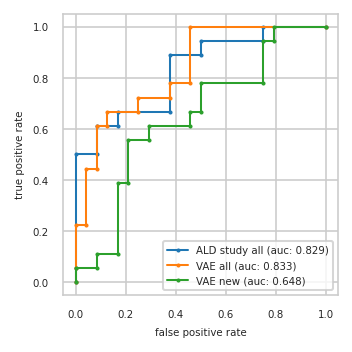

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.500   0.000 0.222   0.083 0.056
3          0.083 0.500   0.042 0.222   0.083 0.111
4          0.083 0.611   0.042 0.444   0.167 0.111
5          0.167 0.611   0.083 0.444   0.167 0.389
6          0.167 0.667   0.083 0.611   0.208 0.389
7          0.375 0.667   0.125 0.611   0.208 0.556
8          0.375 0.889   0.125 0.667   0.292 0.556
9          0.500 0.889   0.250 0.667   0.292 0.611
10         0.500 0.944   0.250 0.722   0.458 0.611
11         0.750 0.944   0.375 0.722   0.458 0.667
12         0.750 1.000   0.375 0.778   0.500 0.667
13         1.000 1.000   0.458 0.778   0.500 0.778
14           NaN   NaN   0.458 1.000   0.750 0.778
15           NaN   NaN   1.000 1.000   0.750 0.944
16           NaN   NaN     NaN   NaN   0.792 0.944
17           NaN   NaN     NaN   NaN   0.792 1.000
18           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,A0A0A0MRJ7;P12259,P08670,P42262;P42262-2;P42262-3
2,P14174,P01011,P30048;P30048-2
3,A0A0C4DGY8;D6RA00;Q9UHY7,Q9Y2T3;Q9Y2T3-3,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
4,P61981,P61981,P31321
5,P04075,P15151-2,Q9NUQ9
6,C9JF17;P05090,P04075,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
7,Q6EMK4,P14174,Q96GD0
8,Q9Y2T3;Q9Y2T3-3,P63104,O95297;O95297-2;O95297-3;O95297-4;Q9UEL6


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


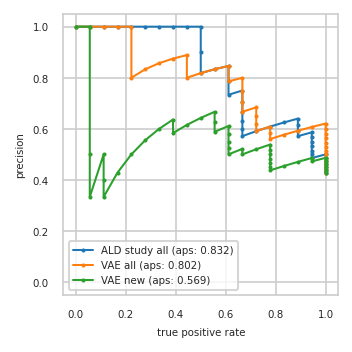

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.486 0.944     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.471 0.889
9          0.515 0.944     0.545 1.000     0.455 0.833
10         0.531 0.944     0.562 1.000     0.438 0.778
11         0.548 0.944     0.581 1.000     0.452 0.778
12         0.567 0.944     0.600 1.000     0.467 0.778
13         0.586 0.944     0.621 1.000     0.483 0.778
14         0.571 0.889     0.607 0.944     0.500 0.778
15         0.593 0.889     0.593 0.889     0.519 0.778
16         0.615 0.889     0.577 0.833     0.538 0.778
17         0.640 0.889     0.560 0.778     0.520 0.722
18         0.625 0.833     0.583 0.778     0.500 0.667
19         0.609 0.778     0.609 0.778     0.522 0.667
20         0.591 0.722     0.591 0.722     0.500 0.611
21         0.571 0.667     0.619 0.722     0.524 0.611
22         0.600 0.667     0.650 0.722     0.550 0.611
23         0.632 0.667     0.684 0.722     0.579 0.611
24         0.667 0.667     0.667 0.667     0.611 0.611
25         0.706 0.667     0.706 0.667     0.588 0.556
26         0.750 0.667     0.750 0.667     0.625 0.556
27         0.733 0.611     0.800 0.667     0.667 0.556
28         0.786 0.611     0.786 0.611     0.643 0.500
29         0.846 0.611     0.846 0.611     0.615 0.444
30         0.833 0.556     0.833 0.556     0.583 0.389
31         0.818 0.500     0.818 0.500     0.636 0.389
32         0.900 0.500     0.800 0.444     0.600 0.333
33         1.000 0.500     0.889 0.444     0.556 0.278
34         1.000 0.444     0.875 0.389     0.500 0.222
35         1.000 0.389     0.857 0.333     0.429 0.167
36         1.000 0.333     0.833 0.278     0.333 0.111
37         1.000 0.278     0.800 0.222     0.400 0.111
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


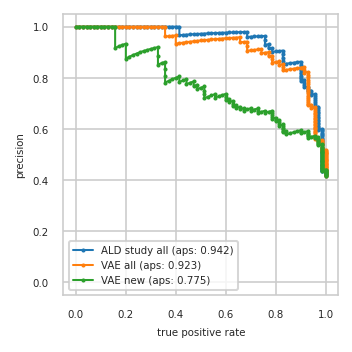

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


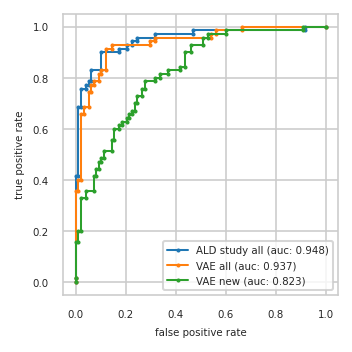

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}